# Car price prediction
In this project, we will predict car prices. We will be working with a data set containing information on various cars, including technical specifications (e.g. motor's displacement, weight, miles per gallon, etc.). The data set and its description can be found [here](https://archive.ics.uci.edu/ml/datasets/automobile). 

## Data import and initial exploration

In [77]:
import pandas as pd
import numpy as np
cars = pd.read_csv('imports-85.data', 
                   names=['symboling', 'normalized-losses', 'make', 
                          'fuel-type', 'aspiration', 'num-of-doors', 
                          'body-style', 'drive-wheels', 'engine-location', 
                          'wheel-base', 'length', 'width', 'height', 
                          'curb-weight', 'engine-type', 'num-of-cylinders', 
                          'engine-size', 'fuel-system', 'bore', 'stroke', 
                          'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 
                          'highway-mpg', 'price'])
cars.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


We will select only the numeric columns with continuous values.

In [78]:
continuous_values_cols = ['normalized-losses', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
numeric_cars = cars[continuous_values_cols]

## Data cleanup

In [79]:
# Replace each '?' by NaN (missing value)
numeric_cars = numeric_cars.replace('?', np.nan)

# Convert columns to numeric (float)
numeric_cars = numeric_cars.astype('float')

# Removal of rows with missing price
numeric_cars = numeric_cars.dropna(subset=['price'])
numeric_cars.isnull().sum()

normalized-losses    37
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
bore                  4
stroke                4
compression-rate      0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 0
dtype: int64

Some rows have more than one missing value. We will remove them. 

In [80]:
numeric_cars = numeric_cars[numeric_cars.isnull().sum(axis=1)<2]
numeric_cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195 entries, 0 to 204
Data columns (total 14 columns):
normalized-losses    160 non-null float64
wheel-base           195 non-null float64
length               195 non-null float64
width                195 non-null float64
height               195 non-null float64
curb-weight          195 non-null float64
bore                 195 non-null float64
stroke               195 non-null float64
compression-rate     195 non-null float64
horsepower           195 non-null float64
peak-rpm             195 non-null float64
city-mpg             195 non-null float64
highway-mpg          195 non-null float64
price                195 non-null float64
dtypes: float64(14)
memory usage: 22.9 KB


For each column, we will replace missing values with the column mean.

In [81]:
numeric_cars = numeric_cars.fillna(numeric_cars.mean())
numeric_cars.isnull().sum()

normalized-losses    0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
bore                 0
stroke               0
compression-rate     0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
dtype: int64

We will normalize each column so that each value is between 0 and 1.

In [82]:
price_col = numeric_cars['price']
numeric_cars = (numeric_cars - numeric_cars.min())/(numeric_cars.max() - numeric_cars.min())
numeric_cars['price'] = price_col

## Univariate models

We will generate several univariate models for price prediction, each based on a single feature. We will test the number of neighbours for each model.

In [83]:
def knn_train_test(train_col, target_col, df):
    np.random.seed(1)
        
    # Randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    # Divide number of rows in half and round.
    last_train_row = int(len(rand_df) / 2)
    
    # Select the first half and set as training set.
    # Select the second half and set as test set.
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    k_values = [1,3,5,7,9]
    k_rmses = {}
    
    for k in k_values:
        # Fit model using k nearest neighbors.
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_df[[train_col]], train_df[target_col])

        # Make predictions using model.
        predicted_labels = knn.predict(test_df[[train_col]])

        # Calculate and return RMSE.
        mse = mean_squared_error(test_df[target_col], predicted_labels)
        rmse = np.sqrt(mse)
        
        k_rmses[k] = rmse
    return k_rmses

k_rmse_results = {}

# For each column (minus `price`), train a model, return RMSE value
# and add to the dictionary `rmse_results`.
train_cols = numeric_cars.columns.drop('price')
for col in train_cols:
    rmse_val = knn_train_test(col, 'price', numeric_cars)
    k_rmse_results[col] = rmse_val

k_rmse_results

{'bore': {1: 9782.241055679857,
  3: 6987.841188454177,
  5: 7076.77561366209,
  7: 7604.132316795714,
  9: 7654.952689987121},
 'city-mpg': {1: 5622.607820583046,
  3: 4206.80832744432,
  5: 4437.412782379445,
  7: 4599.831016942161,
  9: 4520.10890409878},
 'compression-rate': {1: 7083.660420939422,
  3: 6717.9716151019275,
  5: 7020.882647516912,
  7: 6879.383359042175,
  9: 7206.35504394561},
 'curb-weight': {1: 6739.432537578474,
  3: 5187.904039397362,
  5: 4594.66840143918,
  7: 4125.28829394039,
  9: 4175.967095661961},
 'height': {1: 9144.689129517208,
  3: 8163.539469846211,
  5: 7574.683028055379,
  7: 7909.810658286173,
  9: 7609.841226601191},
 'highway-mpg': {1: 5591.286916046342,
  3: 4674.102996268684,
  5: 4409.808045940415,
  7: 4269.119331662173,
  9: 4234.824050221162},
 'horsepower': {1: 4333.419203100009,
  3: 4581.258594235456,
  5: 4543.271115190293,
  7: 4784.710711209458,
  9: 4757.006203766791},
 'length': {1: 5294.122074604657,
  3: 5152.07565848008,
  5: 52

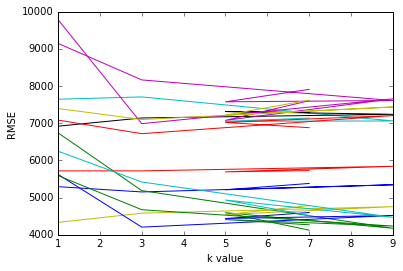

In [86]:
import matplotlib.pyplot as plt
%matplotlib inline

for k,v in k_rmse_results.items():
    x = list(v.keys())
    y = list(v.values())
    
    plt.plot(x,y)
    plt.xlabel('k value')
    plt.ylabel('RMSE')

In [87]:
# Average RMSE across different `k` values for each feature.
feature_avg_rmse = {}
for k,v in k_rmse_results.items():
    avg_rmse = np.mean(list(v.values()))
    feature_avg_rmse[k] = avg_rmse
series_avg_rmse = pd.Series(feature_avg_rmse)
sorted_series_avg_rmse = series_avg_rmse.sort_values()
print(sorted_series_avg_rmse)

sorted_features = sorted_series_avg_rmse.index

horsepower           4599.933166
highway-mpg          4635.828268
city-mpg             4677.353770
curb-weight          4964.652074
width                5118.020804
length               5276.431316
wheel-base           5739.338933
compression-rate     6981.650617
peak-rpm             7179.842705
normalized-losses    7319.890417
stroke               7353.638813
bore                 7821.188573
height               8080.512702
dtype: float64


## Multivariate models
We will modify the function defined above to accept multiple columns.

In [88]:
def knn_train_test(train_cols, target_col, df):
    np.random.seed(1)
    
    # Randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    # Divide number of rows in half and round.
    last_train_row = int(len(rand_df) / 2)
    
    # Select the first half and set as training set.
    # Select the second half and set as test set.
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    k_values = [5]
    k_rmses = {}
    
    for k in k_values:
        # Fit model using k nearest neighbors.
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_df[train_cols], train_df[target_col])

        # Make predictions using model.
        predicted_labels = knn.predict(test_df[train_cols])

        # Calculate and return RMSE.
        mse = mean_squared_error(test_df[target_col], predicted_labels)
        rmse = np.sqrt(mse)
        
        k_rmses[k] = rmse
    return k_rmses

k_rmse_results = {}

for nr_best_feats in range(2,7):
    k_rmse_results['{} best features'.format(nr_best_feats)] = knn_train_test(
        sorted_features[:nr_best_feats],
        'price',
        numeric_cars
    )

k_rmse_results

{'2 best features': {5: 3850.6951958082077},
 '3 best features': {5: 3562.0050421648994},
 '4 best features': {5: 3772.972620940596},
 '5 best features': {5: 3730.9709218915123},
 '6 best features': {5: 3933.0052403748873}}

## Hyperparameter tuning

In [89]:
def knn_train_test(train_cols, target_col, df):
    np.random.seed(1)
    
    # Randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    # Divide number of rows in half and round.
    last_train_row = int(len(rand_df) / 2)
    
    # Select the first half and set as training set.
    # Select the second half and set as test set.
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    k_values = [i for i in range(1, 25)]
    k_rmses = {}
    
    for k in k_values:
        # Fit model using k nearest neighbors.
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_df[train_cols], train_df[target_col])

        # Make predictions using model.
        predicted_labels = knn.predict(test_df[train_cols])

        # Calculate and return RMSE.
        mse = mean_squared_error(test_df[target_col], predicted_labels)
        rmse = np.sqrt(mse)
        
        k_rmses[k] = rmse
    return k_rmses

k_rmse_results = {}

for nr_best_feats in range(2,6):
    k_rmse_results['{} best features'.format(nr_best_feats)] = knn_train_test(
        sorted_features[:nr_best_feats],
        'price',
        numeric_cars
    )

k_rmse_results

{'2 best features': {1: 4050.319435626312,
  2: 3147.7458504103392,
  3: 3321.0321651142367,
  4: 3637.4420099346953,
  5: 3850.6951958082077,
  6: 3838.987047999148,
  7: 3839.9864986844855,
  8: 3862.665519103112,
  9: 3925.4432931992474,
  10: 4061.3079445932594,
  11: 4140.635867573897,
  12: 4335.588126776499,
  13: 4441.022422216654,
  14: 4494.107806074035,
  15: 4531.819602476223,
  16: 4519.885590458795,
  17: 4568.688900479718,
  18: 4623.041062323228,
  19: 4710.274131705177,
  20: 4754.139634007699,
  21: 4790.004351670096,
  22: 4843.723534220048,
  23: 4868.486864680671,
  24: 4852.357687673869},
 '3 best features': {1: 4480.25403684812,
  2: 3557.4090480578816,
  3: 3492.9074437251898,
  4: 3381.491525852647,
  5: 3562.0050421648994,
  6: 3779.233622737123,
  7: 3710.3724823427024,
  8: 3775.406613014095,
  9: 3941.5228770361136,
  10: 4135.572993318003,
  11: 4146.1685481743425,
  12: 4247.6050528777305,
  13: 4325.8889315866745,
  14: 4440.4505074989975,
  15: 4526.275

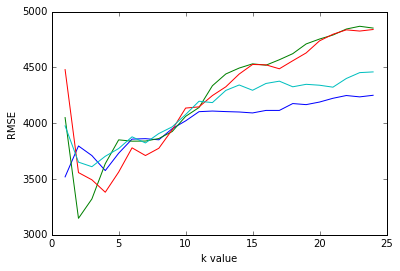

In [90]:
for k,v in k_rmse_results.items():
    x = list(v.keys())
    y = list(v.values())
    
    plt.plot(x,y)
    plt.xlabel('k value')
    plt.ylabel('RMSE')